<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Splitting-the-data" data-toc-modified-id="Splitting-the-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Splitting the data</a></span></li><li><span><a href="#Missing-values" data-toc-modified-id="Missing-values-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Missing values</a></span></li><li><span><a href="#One-hot-encoding" data-toc-modified-id="One-hot-encoding-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>One-hot encoding</a></span></li><li><span><a href="#Feature-scaling" data-toc-modified-id="Feature-scaling-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Feature scaling</a></span></li><li><span><a href="#Final-steps" data-toc-modified-id="Final-steps-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Final steps</a></span></li></ul></li><li><span><a href="#Predictive-modeling" data-toc-modified-id="Predictive-modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Predictive modeling</a></span><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Learning-algorithm" data-toc-modified-id="Learning-algorithm-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Learning algorithm</a></span></li><li><span><a href="#Hyperparameter-Tuning" data-toc-modified-id="Hyperparameter-Tuning-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Hyperparameter Tuning</a></span></li><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Feature Importance</a></span></li><li><span><a href="#Interpreting-the-effect-of-age" data-toc-modified-id="Interpreting-the-effect-of-age-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Interpreting the effect of age</a></span></li></ul></li></ul></div>

In this notebook, we will train a state-of-the-art machine learning model using XGBoost.

Let's start by loading the required libraries and the cleaned data.

In [2]:
# Importing libraries
import pdb 
import glob
import copy
import math
import pickle
import csv
import eli5

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, \
    StratifiedShuffleSplit, cross_val_score, KFold

from sklearn.externals import joblib
from sklearn.utils import resample

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval, pyll
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
   
# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 

# Load line profiler
%load_ext line_profiler

# Adjust number of CPU cores to use
N_JOBS=3

Using TensorFlow backend.


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [4]:
# Load data from previous notebook
all_data = pd.read_csv('../data_raw/all_data.csv')

## Preprocessing

Let's first take another look at the data to make sure everything is alright.

In [5]:
# Inspect data
all_data.head(3)

,Unnamed: 0,age,allsuites,boutique,casino,cbd,category,conference,convention,floors,golf,indoorcorridors,landsf,largestmeetingspace,location,msa,multiproperty,new,operation,portfolio,quarter,resort,restaurant,rooms,saleaffiliation,saleprice,sizesf,ski,spa,id,tract,year,log1_landsf,log1_age,log1_largestmeetingspace,log_saleprice,log_sizesf,log_rooms,log_floors,year_2,year_3,age_2,age_3,floors_2,land,selfrun
0,0,48.0,0.0,0.0,0.0,0.0,Economy Class,0.0,0.0,2.0,0.0,0.0,130301.0,2000.0,Small Metro/Town,"Dothan, AL",0,0,Independent,0,2,0.0,1.0,102.0,Independent,1000000.0,42446.0,0.0,0.0,10,"Dothan/Enterprise, AL",2009,11.777610,3.891820,7.601402,13.815511,10.655988,4.624973,0.693147,4036081,8108486729,2304.0,110592.0,4.0,1,0
1,1,29.0,0.0,0.0,0.0,0.0,Economy Class,0.0,0.0,3.0,0.0,1.0,361548.0,3000.0,Small Metro/Town,"Florence-Muscle Shoals, AL",0,0,Independent,0,2,0.0,1.0,202.0,Independent,1000000.0,151421.0,0.0,0.0,31,Alabama North Area,2010,12.798153,3.401197,8.006701,13.815511,11.927819,5.308268,1.098612,4040100,8120601000,841.0,24389.0,9.0,1,0
2,2,26.0,0.0,0.0,0.0,0.0,Upscale Class,0.0,0.0,4.0,0.0,1.0,357627.0,5400.0,Suburban,"Phoenix-Mesa-Scottsdale, AZ",0,0,Franchise,0,4,0.0,1.0,248.0,Crowne Plaza,24000000.0,142978.0,0.0,0.0,39,"Black Canyon Corridor, AZ",2007,12.787249,3.295837,8.594339,16.993564,11.870446,5.513429,1.386294,4028049,8084294343,676.0,17576.0,16.0,1,0


This shows that we need to drop the first column, which probably was a (meaningless) index that mistakenly was made a column when importing the data. Also, I will drop the binary variable "resort", since resort is also a category of the variable "location".

In [6]:
all_data = all_data.drop(['Unnamed: 0', 'resort', 'land'], axis=1)

### Splitting the data
Let's now start with the actual preprocessing. As mentioned in the introduction and problem statement, an important goal of this project is to show that practitioners influenced predominantly by applied statistics should adopt common practices from machine learning to validate models. (While these approaches may have originated in statistics, the point is that they have only become common practice in machine learning.)

The first such technique is the idea of withholding data (called a test set) when training the model, and then using these withheld data to assess performance. There are two main approaches of how to divide the data into training and test set: We can either split the data randomly, or we can choose a point in time and use all the data originating from an earlier point in time as the training set, and use the later data as the test set.  The former approach works best for independent data, and the latter works best for time-series data.

Our data fall somewhere in between: They are not fully independent, because observations that are closer in time are likely to be more similar, even if we take into account all available predictors. (This is often described as having correlated errors.)  On the other hand, though, we are not dealing with a true time-series, because we are not following the same units over time. (An example of a pooled time-series would be repeated sales data.)  In this true time-series case, we can commonly observe such an extreme serial correlation of errors that this autoregressive process contains more useful information for prediction than the actual features do.

I decided on a compromise: For the test set, I use the latest approximately 20% of the data, which cover the last 1.5 years of the sample. This should make sure we are not overly optimistic, as this makes our calculation of the test accuracy more similar to making predictions for use in practice, when we will probably not have a good estimate of the current year's average price yet. (When I calculate the predictions, I simply treat them as if they were from the last year from which we had data, which should give a better estimate than leaving out the information for year completely, because presumably this year's price will be more similar to last year's prize than to the average price of the last  25 years.)

A disadvantage of this strategy is that the newest portion of the data may not be representative of all years, for example because it is drawn only from a particular point in the business cycle.  However, this is likely not a severe problem for our case, because the business cycle presumably mainly influences the level of the price (captured, in the case of a linear regression model, by the intercept) while the price determinants should stay pretty stable otherwise. To be on the safe side, I do split the data randomly when creating a validation set from the training set when performing cross-validation.  The reason that I pick a different strategy here is that we are not interested in the absolute level of the validation error here, only the relative performance of the different hyperparameters.  As a result, it's not a problem that random splitting causes an optimistic bias, because this should affect all hyperparameters values equally.

Let's now go ahead and see which cut-off we should choose in order to get a test set of about 20% (around 1500 observations). To do so, we group the data by year and count the number of observations per year.  Then we compute the cumulative sum, going backwards.

In [7]:
#  Train-test split
# =================

# Count number of observations by year
year_counts_cum = all_data.loc[:, ["year", "id"]] \
    .groupby("year") \
    .count() \
    .sort_index(ascending=False) \
    .cumsum() 

# Properly name counts
year_counts_cum = year_counts_cum. \
    rename(columns={'id': 'Cumulative Sum (counting backwards)'})

# Print the last 5 years
year_counts_cum.head()

,Cumulative Sum (counting backwards)
year,
2017,601
2016,1917
2015,2751
2014,2756
2013,3497


This shows that, if the data is relatively evenly distributed and 2016, we should cut in the middle of that year.  Thus, let's put all observations that fall in the third quarter 2016 or later into the training set.

In [8]:
# Index for test set
test_index = all_data.loc[
    (all_data.year > 2016) 
    | ((all_data.year == 2016) & (all_data.quarter >= 3))] \
    .index
# Index for training set 
train_index = all_data.index.difference(test_index)

# Check length
print(f'Number of observations in test set: {len(test_index)}')

# Get test and train set
data_test = all_data.loc[all_data.index.isin(test_index)]
data_train = all_data.loc[all_data.index.isin(train_index)]

Number of observations in test set: 1258


This gives us the test set of about 1300 observations.  Let's check the results.

In [9]:
# Check results
assert data_train.year.max() == 2016
assert data_test.year.min() == 2016

Since linear and tree-based models require different preprocessing, we will save another copy to use in another notebook to build a linear model for comparison. 

In [10]:
# Save data to use with linear model
joblib.dump(data_train, '../data/data_train_lin')
joblib.dump(data_test, '../data/data_test_lin')

['../data/data_test_lin']

We also export the data to csv, so we can import them into R to try building a Bayesian hierarchical model. 

In [11]:
#Export file as csv for R
data_train.to_csv('../data_raw/data_train_R.csv',
                  na_rep = "NA", index = False) 
data_test.to_csv('../data_raw/data_test_R.csv', 
                 na_rep = "NA", index = False) 

After saving the data to use with linear models, we can delete polynomial terms, since we will not use these for XGBoost.

In [12]:
# Drop polynomial columns
col2drop = ['year_2','year_3', 'age_2', 'age_3', 'floors_2']
data_train = data_train.drop(col2drop, 1)
data_test = data_test.drop(col2drop, 1)

In [13]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6292 entries, 0 to 7544
Data columns (total 38 columns):
age                         6292 non-null float64
allsuites                   6292 non-null float64
boutique                    6292 non-null float64
casino                      6292 non-null float64
cbd                         6292 non-null float64
category                    6292 non-null object
conference                  6292 non-null float64
convention                  6292 non-null float64
floors                      6292 non-null float64
golf                        6292 non-null float64
indoorcorridors             6292 non-null float64
landsf                      6292 non-null float64
largestmeetingspace         6292 non-null float64
location                    6292 non-null object
msa                         6292 non-null object
multiproperty               6292 non-null int64
new                         6292 non-null int64
operation                   6292 non-null object
p

### Missing values
Let's now talk about missing values.  I decided to drop all observations with missing values rather than in imputing them. (This was already done in the earlier Python files that cleaned the data.) The reason for this is connected to the fact that, as described earlier, I only had access to the original data for the newer  observations.  The older observations already came in merged form, and unfortunately all observations with any missing values had already been dropped. Likewise, many columns that were seen as less important had already been dropped. 

This is because the data were previously used for regression modeling.  As a result, the variables were reduced to a small number deemed most relevant by domain experts. To enable easier modeling, any rows with missing observations were dropped. (This is because the regression models were intended for statistical inference, which requires more complicated imputation than predictive modeling, which is the goal here.  In particular, in order to get correct standard errors, multiple imputation would need to be performed.)

I decided to perform the same  processing on the newer data. This leaves us with 7,500 rather than close to 11,000 observations, and 32 rather than around 100 usable features.  Note that since gradient boosting does not have any trouble dealing with missing values and is able to use even a high number of features, this decision favors ordinary linear regression.  Furthermore, the small size of the data set does not allow gradient boosting to reach anywhere near its full potential.   
This is intentional, because it creates what is sometimes called a **"least likely case"**: If it can be shown that gradient boosting is preferable to linear regression even in such a case that is stacked against it, it makes a stronger case in favor of it if it still prevails.  If we preprocessed the data specifically for gradient boosting (kept all possible features) and as we increase the number of observations (don't drop  observations with missing values, and collected more data over time), the superiority of gradient boosting will be more pronounced.


### One-hot encoding
Next, let's talk about the encoding of categorical and ordinal variables.  I took different steps here for different models: For gradient boosting, I performed one-hot encoding for actual categorical variables, but mapped categorical variables that were in fact ordinal to integers corresponding to the correct order. This works because tree-based models do not distinguish between ordinal and numeric variables.  By contrast, for linear regression, I will perform one-hot encoding for both categorical and ordinal variables.  Leaving ordinal variables as numeric would otherwise amount to assuming that the differences between categories are equal, which is usually not the case.

We start by finding all variables encoded as categorical.

In [15]:
# Get non-numeric columns
data_train.select_dtypes(
    include=['object']
    ) \
    .columns

Index(['category', 'location', 'msa', 'operation', 'saleaffiliation', 'tract'], dtype='object')

In [16]:
# Get non-numeric columns
data_train.select_dtypes(
    include=['object']
    ) \
    .columns

Index(['category', 'location', 'msa', 'operation', 'saleaffiliation', 'tract'], dtype='object')

Many of the variables in the data sets are already binary variables indicating whether certain features are present.  There are still a number of categorical variables left, though, that we need to transform.  
We will start with the hotel category, which ranges from economy class to luxury class. Since this implies a  ranking, it is not truly categorical but ordinal. Thus, let's map it to consecutive integers. (Remember that we already saved another version of the data that we will use for linear models, so we can perform different preprocessing steps there.)

In [17]:
## Make hotel category ordinal
# Define mapping
category_map = {
    'Economy Class': 1,
    'Midscale Class': 2,
    'Upper Midscale Class': 3,
    'Upscale Class': 4,
    'Upper Upscale Class': 5,
    'Luxury Class': 6
}
# Apply mapping to training and test set
data_train.loc[:, 'category'] = data_train.category \
                                 .map(category_map)
data_test.loc[:, 'category'] = data_test.category \
                                 .map(category_map)

Now we can perform one-hot encoding of the remaining categorical variables.

In [18]:
# Categorical variables
cats = ['msa', 'tract', 'location', 
        'saleaffiliation', 'operation']
# Perform one-hot encoding
ohe = OneHotEncoder(handle_unknown='ignore',
                    sparse=False)
X_train_cats = ohe.fit_transform(
    data_train.loc[:, cats])        
X_test_cats = ohe.transform(
    data_test.loc[:, cats])

Let's merge those one-hot encoding categorical variables with the rest of the features to create the data to pass to the model. In this process, I get rid of two variables that are not relevant, the ID as well as the variable "new", which was used during the data cleaning process to distinguish the data stemming from the older and newer wave.

In [19]:
# List of variables to exclude from X
v2exclude = list(
    data_train.columns[
    data_train.columns.str.startswith('log')])
v2exclude.extend(
    ['saleprice', 'id', 'new'])
# Print to make sure no variables that accidentally 
# start with "log" are excluded
print('Variables excluded: ', v2exclude)

# Non-categorical columns for X
X_train_rest = data_train.drop(cats + v2exclude,
                               axis=1)
X_test_rest = data_test.drop(cats + v2exclude,
                             axis=1)
# Merge categorical and non-categorical variables
X_train = np.concatenate([X_train_rest, X_train_cats], 
                         axis=1)
X_test = np.concatenate([X_test_rest, X_test_cats], 
                         axis=1)

# Get feature names
feature_names = list(X_train_rest.columns) \
    + list(ohe.get_feature_names())

# Create target variables
y_train = data_train.loc[:, 'log_saleprice']
y_test = data_test.loc[:, 'log_saleprice']

Variables excluded:  ['log1_landsf', 'log1_age', 'log1_largestmeetingspace', 'log_saleprice', 'log_sizesf', 'log_rooms', 'log_floors', 'saleprice', 'id', 'new']


### Feature scaling
Note that I did not perform any standardization, because it is not necessary for the models I use: As already mentioned, gradient boosting does not care about the distribution of the data, because it treats them as ordinal.  For linear regression, standardization can be useful to speed up convergence of gradient descent, but our data set is so small that this is not an issue.  Thus, I left variables at the original scale, which has the additional benefit of making the coefficients of linear regression more easily interpretable.

### Final steps
We can now save the final form of the preprocessed data, so we don't have to repeat those steps the next time we load the notebook.

In [20]:
# Save preprocessed training and test sets
filenames = ['X_train', 'X_test',
             'y_train', 'y_test']
files = [X_train, X_test, y_train, y_test]

for file, filename in zip(files, filenames):
    joblib.dump(file,
                '../data/{}.joblib'.format(filename))
# Delete temporary list to conserve memory
del files

# Also save feature names
joblib.dump(feature_names, '../data/feature_names.joblib')

['../data/feature_names.joblib']

Finally, we convert the data to XGBoost's native format. (This is necessary because we use XGBoost's native API rather than the Scikit-learn API, because this brings a number of performance advantages when training the model.)

In [12]:
# Convert data to DMatrix 
data_xgb_train = xgb.DMatrix(data=X_train, label=y_train,
                             feature_names=feature_names, nthread=-1)
data_xgb_test = xgb.DMatrix(data=X_test, label=y_test,
                            feature_names=feature_names)

## Predictive modeling
### Goal

The main goal of this analysis is to show that models of hotel property prices should use machine learning techniques that are able to model more complex relationships between variables, rather than using the linear regression models that have been traditionally the main workhorse for statistical inference. 
 A secondary goal of mine is to show that if linear regression models are used – e.g. as a first step or a point of comparison – it still pays to borrow two related techniques from machine learning, regularization and the practice of assessing the performance of the model by measuring performance on withheld data. 
 
While cross-validation may have originated in statistics, the most common way of assessing the trustworthiness of a model in applied statistics is based on verifying theoretical assumptions combined through model checking, e.g. analysis of the residuals.  By contrast, it is common practice in machine learning to instead verify the fit of a model through more direct means, namely by withholding part of the data and then assessing the model's performance on the withheld data.  This is usually preferable because it avoids relying on dubious assumptions about the distribution of the data.  Furthermore, in practice, model checking is often neglected, or the findings are not presented with the results.  Furthermore, the model checking that is done tends to be biased towards not rejecting wrong models. This is probably a major cause of the replication crisis in many scientific disciplines .  For a more in-depth discussion of these issues, see Leo Breiman's famous paper "Statistical modeling: The two cultures," which is available at http://www2.math.uu.se/~thulin/mm/breiman.pdf.

The second technique borrowed from machine learning that should be standard practice in applied statistics is regularization.  The purpose is to avoid overfitting our model to the data we train our model on.  This problem is usually dealt with in applied statistics by practices such as using the adjusted R_2 for model selection.  However, the adjustment of the R_2 for the lost degrees of freedom is not rooted in any principled way.  By contrast, fit statistics derived from information theory, such as AIC or BIC, are based on a theoretical framework that tries to adjust for the overfitting to the training set.  However, these are not only much less widely used than the adjusted R_2, but are also based on a lot of assumptions about the distribution of our data that are rarely completely satisfied in practice.  As a result, it is often hard to say how confident we can be in its prescriptions.

One might think that for our sample size of over 7000, regularization might not be that important for a simple linear model.  However, remember that we had three categorical variables with several hundred different categories.  If we perform one-hot encoding on these, we end up with about 1000 predictors. Since two out of these three categorical variables refer to the location of the property (e.g., the Metropolitan Statistical Area ), we can expect that it would indeed be useful if we could include these variables.  The only good way to find out if it is worth losing so many degrees of freedom is to estimate the model on part of the data and then seeing which model performs better on the withheld data.

### Learning algorithm
As already mentioned, I chose gradient boosting, since it is known to be the best performing machine learning algorithm on anything but huge data sets. The particular version I choose, XGBoost, is particularly fast and accurate.

A good explanation of how gradient boosting (and XGBoost in particular) works can be found here:
https://xgboost.readthedocs.io/en/latest/tutorials/model.html

### Hyperparameter Tuning

To tune the hyperparameters, I will rely on **Bayesian hyperparameters optimization** using **hyperopt**. The advantage of this approach is that it performs an *intelligent* search that gives better performance for a given computational budget: We start by specifying a prior distribution for the hyperparameters. This formalizes our beliefs about which hyperparameters make sense *before we have seen the data.* Like randomized search but unlike grid search, this gives us the chance to not only specify the minimum and maximum values between which to confine our search, but it also allows us to concentrate probability mass around the most likely values in the center (e.g., through a (log)normal distribution), so that more plausible values are tried more frequently than possible but unlikely values. 

By contrast to a randomized search, however, we learn from the results from previous iterations: We start with the prior distribution that we defined above, and update our confidence about where the optimal hyperparameters lie after each trial. The distribution after each update is called the posterior distribution (it is a conditional probability, given the prior as well as the evidence observed so far). If the last values we tried gave us a good result on the validation set, it is likely that we have been moving in the right direction (and vice versa), and we update the probability distribution accordingly. The rules about how to update our confidence about which hyperparameters are optimal are defined by Bayes's Rule. In the beginning, when we have gathered few actual data, our posterior distribution will mainly be determined by the prior distribution we started with. But as we gather more evidence by trying additional hyperparameter combinations, the prior distribution will be swamped by the evidence from these trials and will concentrate more and more probability mass around the values that worked well.

Thus, for the first few iterations, the results will be similar to randomized search that draws hyperparameters from the same distributions that we use for our prior distributions. However, as we try more and more hyperparameters combinations, Bayesian optimization will increasingly concentrate our efforts on the subset of the search space that worked best previously. This is particularly important for models where we have many hyperparameters to tune (e.g., XGBoost). While randomized search is preferable to grid search, it still runs into the curse of dimensionality, because it becomes increasingly unlikely that a good combination of hyperparameters is selected randomly as the number of hyperparameters increases. Overall, thus, Bayesian optimization allows us to get a better accuracy for a given computational cost, or it allows us to attain a given accuracy at a (often much) lower computational cost.

One problem I faced when implementing this search using hyperopt is that this package only offers a limited choice of prior distributions. In particular, while I wanted to use a lognormal distribution for many variables, I also wanted to set a strict upper and lower bounds.  For example, for SVMs I wanted to avoid excessively high values for C, because this can increase training time by an order of magnitude.  An even bigger problem was that there were no good options to sample parameters that need to be integers, and that functions that were supposed to sample integers rounded from a normal distribution failed  to perform this type conversion.  Thus, I added a custom function for each learner that adjusts (rounds or converts) the parameters sampled by hyperopt before they are passed to the model.

For gradient boosting, the performance of a given set of hyperparameters will be evaluated using 10-fold cross-validation.  For the linear models, I will use 20 folds, because training is much faster here. The metric I optimize is mean-squared error, which is common practice for regression models. 

Since we have a lot of parameters to tune, we need a smart way of searching over the different parameters to avoids the combinatorial explosion that would result from a simultaneous grid search over all parameters. Doing so more efficiently was the initial motivation for me to explore Bayesian hyperparameter optimization for a previous project.

In the following, I will follow the suggestions from https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ for plausible ranges for the hyperparameters. For the exact parameters required to get sensible prior distributions, I reuse values from a previous project.

However, since I will use Bayesian optimization rather than brute force, I improve on the strategy from the above block post by avoiding the lazy approach of repeatedly optimizing a subset of the parameters at a time. Instead, I will optimize all tree-specific parameters at once. I again follow the suggestion from the blog post of first using a relatively higher learning rate to speed up training. Subsequently, I will reestimate the model with the parameters identified in the previous step but using a smaller learning rate for another increase in accuracy. 

During both of these steps, I will use early stopping to determine the optimal number of trees. 

Let's start by specifying the prior distributions of the hyperparameters we want to optimize.

In [ ]:
# Set options
MAX_EVALS = 150
N_FOLDS = 10
N_JOBS = 3

small_number = 0.01 # To adjust lower bound for Gamma
space = {
    # Parameters that we are going to tune (Note that these may be modified
    # in objective function to convert to integer or to set min or max.)
    'objective':'reg:linear',
    'metrics': 'rmse',
    'eta':.3,  # Start with a higher learning rate for speed
    'max_depth': hp.normal('max_depth', 6, 2),
    'min_child_weight': hp.normal('min_child_weight', 4, 2), 
    'gamma': hp.loguniform('gamma', # small number will be subtracted later
                            np.log(small_number), 
                            np.log(0.5 + small_number)),
    'subsample': hp.normal('subsample', 0.75, 0.2), 
    'colsample_bytree':  hp.normal('colsample_bytree', 0.75, 0.2),
    'reg_alpha': hp.loguniform('reg_alpha', -6, 4),
    'num_boost_round': 10000,  # Max number of iterations 
    'nthread': N_JOBS
}

As mentioned above, XGBoost only gives limited flexibility of how to define these  distributions (In part because functions that were supposed to sample integers did not work properly).  Thus, I define a function that will adjust the sampled hyperparameters values to make sure they fall into the right range and have the right data type.

In [8]:
# Function to convert sampled parameters to integer or make positive, etc., 
# where necessary
def adjust_params_xgb(params):
    """ 
    Adjust parameters where hyperopt did not allow sampling from optimal 
    distribution.
    """

    # Convert sampled parameters to integer, where  applicable
    params['max_depth'] = round(params['max_depth'])
    
    # Make sure min_child_weight is positive
    if params['min_child_weight'] <= 0:
        params['min_child_weight'] = 0 # Set to lower bound
   
    # Subtract the small number from gamma to set 0 as lower bound
    params['gamma'] = params['gamma'] - small_number

    # Set upper or lower bunds for parameters, where applicable
    if params['max_depth'] <= 2:
        params['max_depth'] = 2
    if params['subsample'] < 0.05:
        params['subsample'] = 0.05
    if params['subsample'] > 1:
        params['subsample'] = 1
    if params['colsample_bytree'] < 0.05: 
        params['colsample_bytree'] = 0.05
    if params['colsample_bytree'] > 1:
        params['colsample_bytree'] = 1
    
    # Return modified parameters
    return params

Now we are able to carry out the optimization.

In [ ]:
# CSV file to track progress
progress_file_path = 'progress_xgb.csv'
with open(progress_file_path, 'w') as file:
    writer = csv.writer(file)
    # Write header to the file
    writer.writerow(['loss', 'params', 'n_trees'])
    
complete_results = {}
counter = 0
# Objective function to minimize
def objective(params, progress_file_path=progress_file_path,
              n_jobs=N_JOBS):
    """Objective function to minimize"""
    
    # Adjust parameters
    params = adjust_params_xgb(params)

    # Perform cross-validation to assess RMSE (w/ early stopping)
    # Note: It is crucial that early_stopping_rounds are supplied as a
    # direct argument rather than in the parameters dictionary! Not sure 
    # why.)
    xgb_cv = xgb.cv(params, dtrain=data_xgb_train, 
                    num_boost_round=10000,  # Max number of iterations 
                    early_stopping_rounds=50,
                    seed=1,
                    nfold=N_FOLDS)

    # Extract best performance
    best_ntree = xgb_cv.loc[:, 'test-rmse-mean'].idxmin()
    best_rmse = xgb_cv.loc[:, 'test-rmse-mean'].loc[best_ntree]
    
    global complete_results
    global counter 
    complete_results[counter] = xgb_cv
    counter += 1
    
    # Save results to csv file
    with open(progress_file_path, 'a') as file:
        writer = csv.writer(file)
        writer.writerow([best_rmse, params, best_ntree])

    # Return results
    return {'loss': best_rmse, 'params': params, 'n_trees': best_ntree, 'status': STATUS_OK}

# Minimize objective
best = fmin(objective, space, algo=tpe.suggest,
            max_evals=MAX_EVALS)

# Get the values of the optimal parameters
best_params = space_eval(space, best)

# Save best parameters
joblib.dump(best_params, 'saved_models/xgb_best_params.joblib')

Let's take a look how the performance changed over time during the hyperparameters optimization:

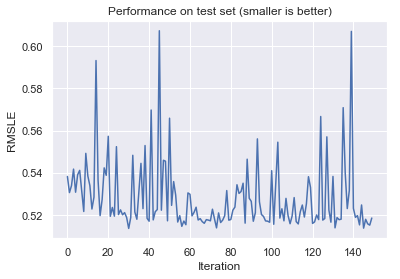

In [44]:
# Load full results from progress file
xgb_results = pd.read_csv('progress_xgb.csv')

# Get validation score
# Extract RMSLE for each iteration
rmsle_xgb = xgb_results.loss

# Plot RMSLE per iteration
rmsle_xgb.plot()
plt.title('Performance on test set (smaller is better)')
plt.ylabel('RMSLE')
plt.xlabel('Iteration');

We see that we do not get any noticeable improvement after about 70 iterations. However, this is hard to predict beforehand, and I wanted to squeeze out every bit of accuracy since our data set is so small, so it Notice was still good to err on the side of caution.

We should also check the number of trees at which the optimum was reached to make sure that it was before the maximum number of iterations. If this is not the case, we would have to either increase the maximum number of iterations (or set a higher learning rate).

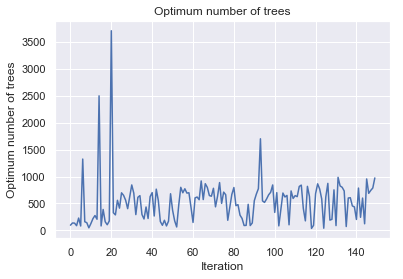

In [45]:
# Extract optimal number of trees for each iteration
n_trees = xgb_results.n_trees

# Plot RMSLE per iteration
n_trees.plot()
plt.title('Optimum number of trees')
plt.ylabel('Optimum number of trees')
plt.xlabel('Iteration');

This looks good. For all iterations, the optimum was reached before arriving at the maximum number of iterations, 10,000.

Let's now assess the performance of the model on the test set.  To do so, we first re-estimate the model on the whole training set, using the optimal number of trees derived previously.

In [46]:
# Get the number of trees at optimum
n_trees_optimum = int(  # Convert series of length 1 to integer 
    xgb_results.loc[xgb_results.loss == xgb_results.loss.min(), 
                    'n_trees']
)

In [ ]:
# Get best parameters (adjusted)
best_params = adjust_params_xgb(best_params)
# Train the model with the optimal hyperparamters (including number of
# trees) on the whole training set
xgb_best = xgb.train(best_params,
                     num_boost_round=n_trees_optimum,
                     dtrain=data_xgb_train)

In [48]:
# Compute predicted values and save
y_xgb = xgb_best.predict(data_xgb_test)
y_xgb.dump('../saved_models/y_xgb')
    
# Compute explained variance (test set)
r2_xgb = r2_score(y_test, y_xgb)
print(f'R_2 test set: {r2_xgb}')

R_2 test set: 0.849985438767737


We see that our model explains about 85% of the variation of the test set. This seems good, but it's hard to say how good this really is before we have a baseline estimate from the linear model.

Let's save this model.

In [86]:
# Save intermediate model
joblib.dump(xgb_best, '../saved_models/xgb_.joblib')
# with open('data/xgb_.pickle', 'wb') as pickled_file: 
#     pickle.dump(xgb_best, pickled_file) 
# Save  iteration of best parameters
best_params_ = best_params
# Save best parameters
joblib.dump(best_params_, '../saved_models/xgb_best_params_.joblib')

['saved_models/xgb_best_params_.joblib']

Now that we have identified the best parameters, let's re-estimate the model with a lower learning rate to get a final boost in accuracy.

In [9]:
# Set other constants again, if necessary
small_number = 0.01
# Load and adjust best parameters from disk, if necessary
best_params = joblib.load('../saved_models/xgb_best_params.joblib')
best_params = adjust_params_xgb(best_params)
# Load model, if necessary
xgb_best = joblib.load('../saved_models/xgb_.joblib')

In [ ]:
# Decrease learning rate
best_params['eta'] = 0.01
# Delete number of iterations from parameters (It has to be
# supplied as a direct argument to work properly.)
del best_params['num_boost_round'] 

We start by performing cross-validation again in order to find the right number of trees for the lower learning rate. The other parameters will carry over from the previous model, since tree-specific parameters should not be affected by using a different learning rate.

In [ ]:
# Fit the model with the optimal hyperparamters and lower learning rate
xgb_final_cv = xgb.cv(best_params,
                  dtrain=data_xgb_train, 
                  num_boost_round=1000000,
                  early_stopping_rounds=10000,
                  nfold=10)

In [38]:
# Get optimal number of trees, save and add to parameters
n_trees_optimum_final = xgb_final_cv.loc[:, 'test-rmse-mean'] \
                            .idxmin()
joblib.dump(n_trees_optimum_final, '../saved_models/n_trees_optimum_final')

['../saved_models/n_trees_optimum_final']

Now we are ready to estimate the model on the whole training set, using the number of trees identified above.

In [ ]:
# Re-estimate model on complete training set with 
# optimum number of parameters
xgb_final = xgb.train(best_params,
                     num_boost_round=n_trees_optimum_final,
                     dtrain=data_xgb_train)

# Save model
joblib.dump(xgb_final, '../saved_models/xgb_final.joblib')
# Save predictions
joblib.dump(y_xgb_final, 
            '../saved_models/y_xgb_final.joblib')    
# Save final iteration of best parameters
best_params_final = best_params
joblib.dump(best_params_final, 
            '../saved_models/xgb_best_params_final.joblib')

In [9]:
# Load, if necessary
xgb_final = joblib.load('../saved_models/xgb_final.joblib')    

Let's compute predictions on the test set and calculate the R_2.

In [14]:
# Computer predicted values
y_xgb_final = xgb_final.predict(data_xgb_test)

In [17]:
# Compute explained variance (test set)
r2_xgb_final = r2_score(y_test, y_xgb_final)
r2_xgb_final.dump('../saved_models/r2_xgb.joblib')
print(f'R_2 test set: {r2_xgb_final}')

R_2 test set: 0.8517936519666849


This gave us only a small boost in performance. This may be due to the fact that we only have a small dataset, so probably the learning algorithm already came close to its capacity despite the large learning rate. Again, it was still worth trying, because it is risky to trust intuition we may have about this beforehand.

### Feature Importance
Let's now plot the most important features.

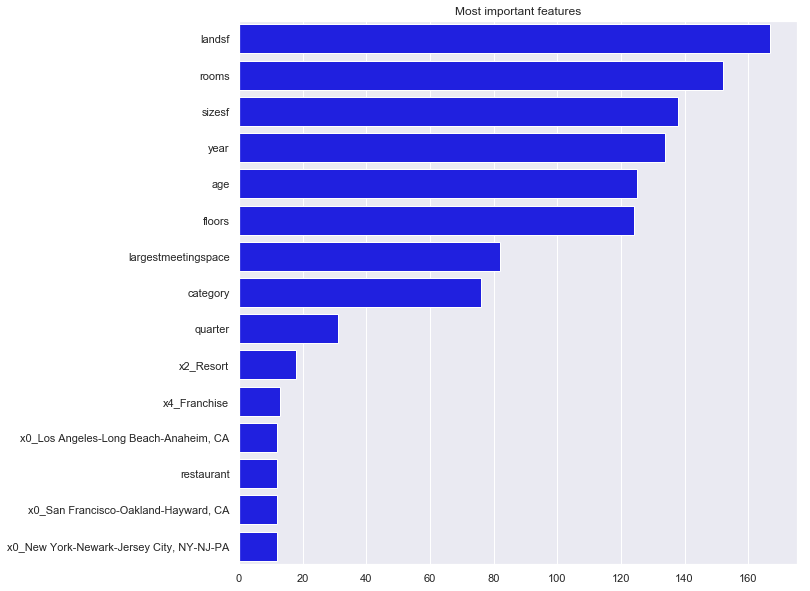

In [49]:
# Save feature importances
fi_xgb = pd.Series(
    xgb_best.get_fscore()) \
            .sort_values(ascending=False) \
            .head(15)
joblib.dump(fi_xgb, 'saved_models/fi_xgb.joblib')

# Plot
plt.figure(figsize=(10,10))
sns.barplot(x=fi_xgb, y=fi_xgb.index, 
            color='blue')
plt.title('Most important features')
plt.show();

Not surprisingly, variables affecting the size of the hotel are most predict if of price. Note that the location variables (e.g., MSA) are likely to be even more important, but these are treated as a separate variable for each category due to one-hot encoding.

Note that this plot does not tell us anything about what exactly the effect of a particular feature is, only how often it was used in splitting.  Let's thus think about how we could get more interpretable results about a particular feature of interest.

### Interpreting the effect of age
As mentioned above, I argue that it is not the "fault" of more complex machine learning models that they lack easy interpretability; rather, reality is too complex to fit well into simple linear models.  Thus, better fitting models inevitably tend to be less interpretable, but this is simply due to the limitations of the human mind.  While interpretability is good to have, it is not worth sacrificing accuracy and fit.

I illustrate this problem by looking at the effect of age. This variable is of particular interest, because it is likely to have a more non-linear effect than other important variables, such as those related to size. Gradient boosting is able to model both the nonlinear impact of a feature, as well as the interaction between different features.  In order to make the effect of age more interpretable, I abstract from the interaction, and simply calculate the effect of age, averaged over all situations.  To do so, I use a resampling technique: I draw a large number of samples, but randomly assign age values to them.  Then, I generate predictions, and plot how the average prediction varies by age.

Let's start by creating the resampled test set:

In [ ]:
# Create resampled test set 
X_test_r, y_test_r = resample(
    X_test, y_test,
    replace=True, n_samples=1000000, random_state=1)

# Convert X_test to DataFrame for easier manipulation
X_test_r = pd.DataFrame(X_test_r, columns = feature_names)
# Draw uniformly distributed age values
# X_test[:, feature_names=='age']
age_r = resample(
    np.arange(X_test_r.age.min(),
              X_test_r.age.max(),
              1),
    replace=True, n_samples = 1000000, random_state=2)             

We can now set these values as the age of our resampled data frame and compute the predictions. Finally, we will group these predictions by age, and subtract the mean price.

In [ ]:
# Replace age with randomized values
X_test_r.loc[:,'age'] = age_r

# Convert X_test_r back to NumPy array
X_test_r = X_test_r.values

# Convert data to DMatrix 
data_xgb_test_r = xgb.DMatrix(data=X_test_r, label=y_test_r,
                            feature_names=feature_names)

# Make predictions
y_xgb_r = xgb_best.predict(data_xgb_test_r)
# Group predictions by age 
y_by_age = pd.Series(y_xgb_r) \
    .groupby(age_r).mean()
# Center predictions
y_by_age_centered = y_by_age - y_test.mean()

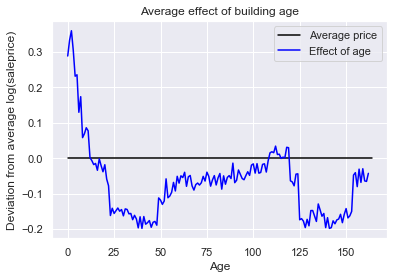

In [94]:
plt.title('Average effect of building age')
plt.xlabel('Age')
plt.ylabel('Deviation from average log(saleprice)')
plt.plot(np.arange(165), np.zeros(165),
         'black', label='Average price')
plt.plot(y_by_age_centered, 
         'blue', label='Effect of age')
plt.legend()
plt.show()

In [1]:
import os
os.system('jupyter nbconvert --to html 1_modeling_xgb.ipynb')

0